# Import Library

In [64]:
import pandas as pd
import numpy as np
from numpy.lib import recfunctions as rfn
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import *
from sklearn.model_selection import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.layers.core import Dropout
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [65]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [67]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


# Exploratory Data Analysis

Because most of them are categorical, for visualization purpose we gonna do `Label Encoding` for that

In [68]:
df_viz = df.copy()

In [69]:
df_viz.drop(columns= 'customerID', inplace=True)
df_viz['TotalCharges'] = pd.to_numeric(df_viz['TotalCharges'], errors='coerce')
df_viz['SeniorCitizen'] = df_viz['SeniorCitizen'].map({0: 'No', 1: 'Yes'})
cat = df_viz.select_dtypes('object').columns
cat

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object')

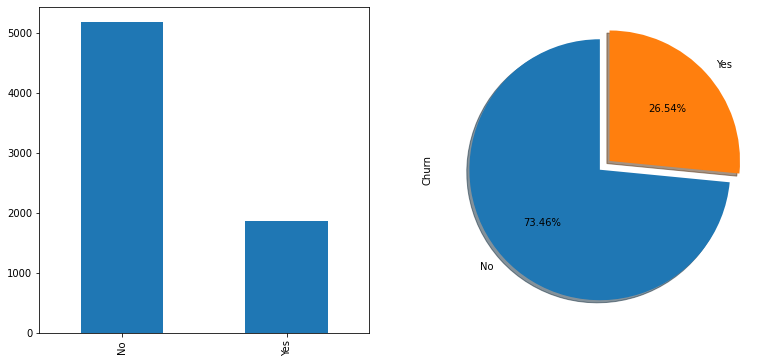

In [70]:
fig, ax = plt.subplots(ncols=2, figsize=(13, 6))
df_viz['Churn'].value_counts().plot(kind= 'bar', ax=ax[0])
df_viz['Churn'].value_counts().plot.pie(autopct='%.2f%%', ax=ax[1], explode = [0, 0.1], shadow= True, startangle=90)
plt.show()

Data is unbalance, as we can see there is more customer who `Not Churn` instead of `Churn`

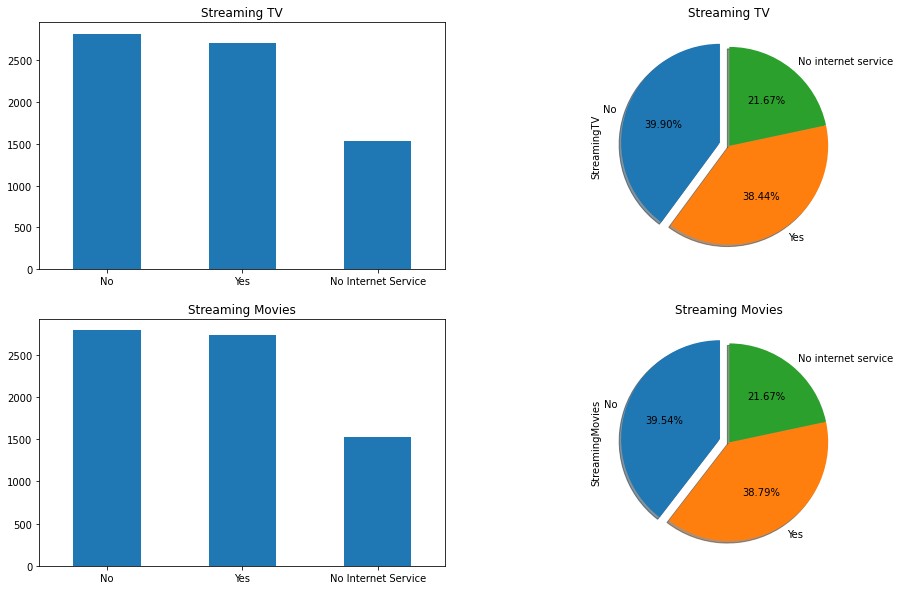

In [71]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16, 10))
df_viz['StreamingTV'].value_counts().plot(kind= 'bar', ax=ax[0, 0])
df_viz['StreamingTV'].value_counts().plot.pie(autopct='%.2f%%', ax=ax[0, 1], explode = [0.1, 0,0], shadow= True, startangle=90)
df_viz['StreamingMovies'].value_counts().plot(kind= 'bar', ax=ax[1, 0])
df_viz['StreamingMovies'].value_counts().plot.pie(autopct='%.2f%%', ax=ax[1, 1], explode = [0.1, 0, 0], shadow= True, startangle=90)
ax[0, 0].set_xticklabels(['No', 'Yes', 'No Internet Service'], rotation=0)
ax[1, 0].set_xticklabels(['No', 'Yes', 'No Internet Service'], rotation=0)
ax[0, 1].set_title("Streaming TV")
ax[1, 1].set_title("Streaming Movies")
ax[0, 0].set_title("Streaming TV")
ax[1, 0].set_title("Streaming Movies")
plt.show()

Probably the service of the product are `Streaming TV` including `Streaming Movies`, it is because there is no difference between both of them

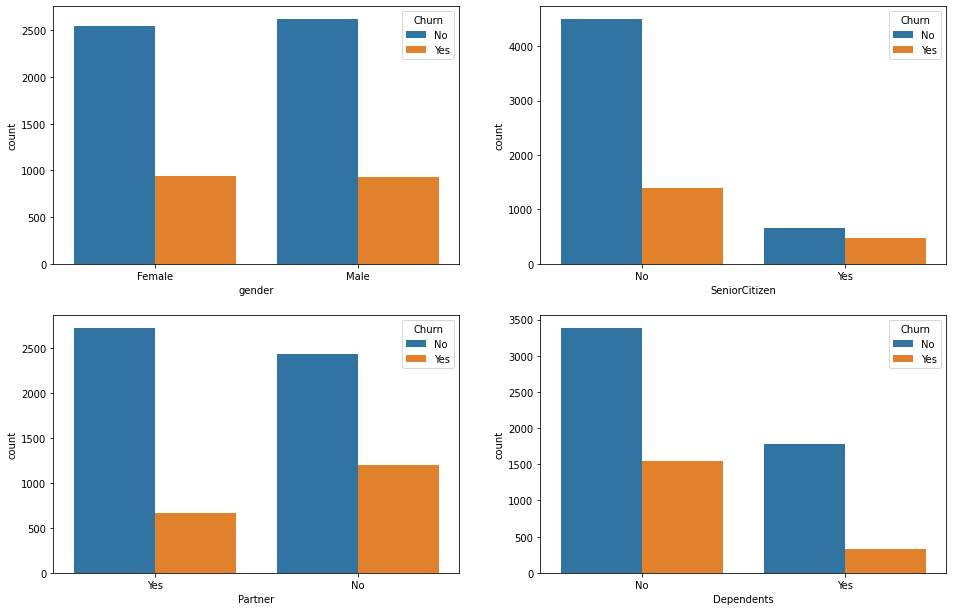

In [72]:
customer = df_viz[['gender', 'SeniorCitizen', 'Partner', 'Dependents']]
plt.figure(figsize=(16,90))
for i, col_cat in enumerate(customer):
    ax = plt.subplot(16, 2, i+1)
    sns.countplot(x=df_viz[col_cat], hue=df_viz['Churn'], data= df_viz, ax=ax)
plt.show()

We could say that:
- `Gender` does not affect the chance of customer who *Churn* or not
- `Senior Citizen` not likely to Churn, **maybe** it's because they don't like to spend their time to watch movies/TV anymore, and in this data there is less of them compare to customer who younger than them who tend to *Churn* more 
- Most of Customer who likely to *Churn* are people who don't have `Partner`
- Customer who don't have `Dependents` tend to *Churn*, **maybe** it's just because they like to spend their time alone and it has to do with `Partner`

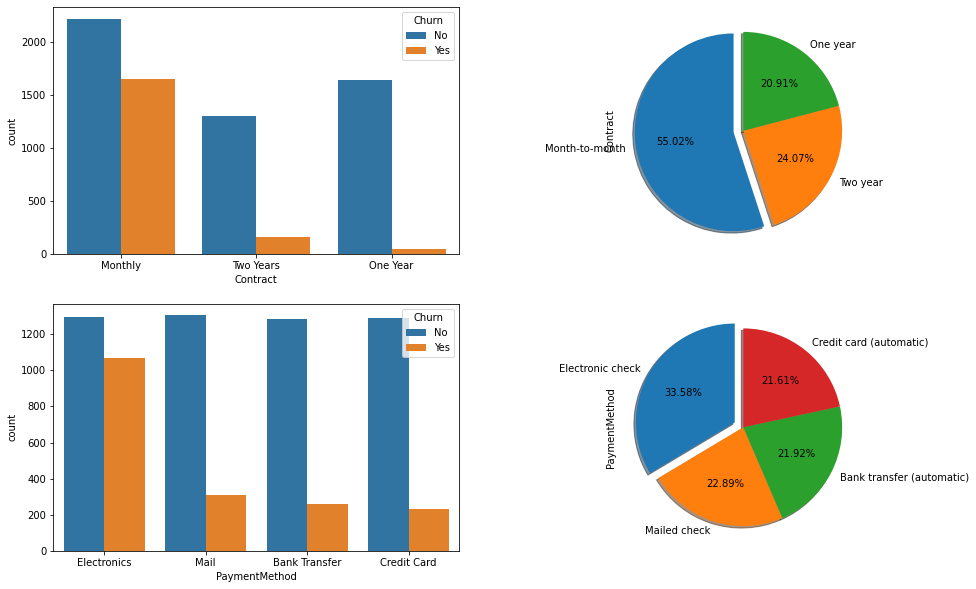

In [73]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16, 10))
sns.countplot(df_viz['Contract'], hue= df_viz['Churn'], ax=ax[0,0])
df_viz['Contract'].value_counts().plot.pie(autopct='%.2f%%', ax=ax[0,1], explode = [0.1, 0, 0], shadow= True, startangle=90)
sns.countplot(df_viz['PaymentMethod'], hue= df_viz['Churn'], ax=ax[1,0])
df_viz['PaymentMethod'].value_counts().plot.pie(autopct='%.2f%%', ax=ax[1,1],explode = [0.1, 0, 0, 0], shadow= True, startangle=90)
ax[0, 0].set_xticklabels(['Monthly', 'Two Years', 'One Year'], rotation=0)
ax[1, 0].set_xticklabels(['Electronics', 'Mail', 'Bank Transfer', 'Credit Card'], rotation=0)
plt.show()

- We can see that Customer more often to *Churn* when they only `Contract` **Monthly**, and customer who *Churn* with **One Year** more less than customer with `Contract` **Two Year**
> It's maybe because people more likely to update their `Contract` instead of subscribe for long period time but not used effectively

- And more people like to use `Electronic payments` for update their `Contract`
> Maybe because it's easier than other payment method and more have a discount

In [74]:
numeric = df_viz.select_dtypes('number')

In [75]:
df_viz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


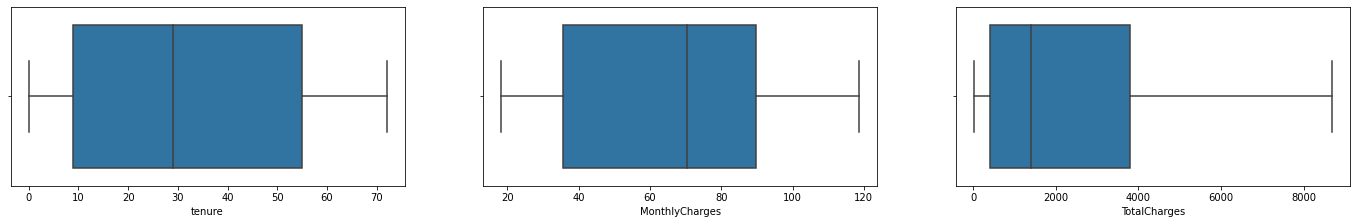

In [76]:
plt.figure(figsize=(24,27))
for i, col in enumerate(numeric):
    ax = plt.subplot(7, 3, i+1)
    sns.boxplot(x=df_viz[col])
    # plt.title(col, pad=1)

There is no `Outliers` so we don't need to deal with them and can continue

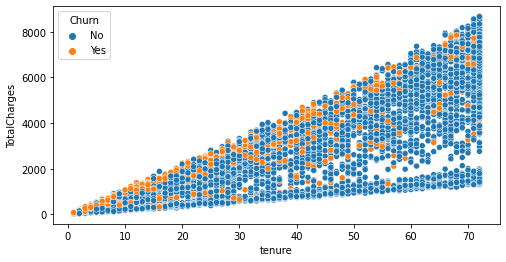

In [77]:
plt.figure(figsize=(8, 4))
sns.scatterplot(df_viz['tenure'], df_viz['TotalCharges'], hue= df_viz['Churn'])
plt.show()

We can tell that customer with low tenure has more chance to `Churn` compare with customer who doesn't, and of course the longer you being customer more `Total Charges` you've paid. As we told before on the `Contract` graph that customer have tendency to `Churn` with short period of time for being their customer

In [78]:
label = LabelEncoder()
labeling = df_viz.copy()
for i in labeling.select_dtypes('object'):
  labeling[i] = label.fit_transform(labeling[i])

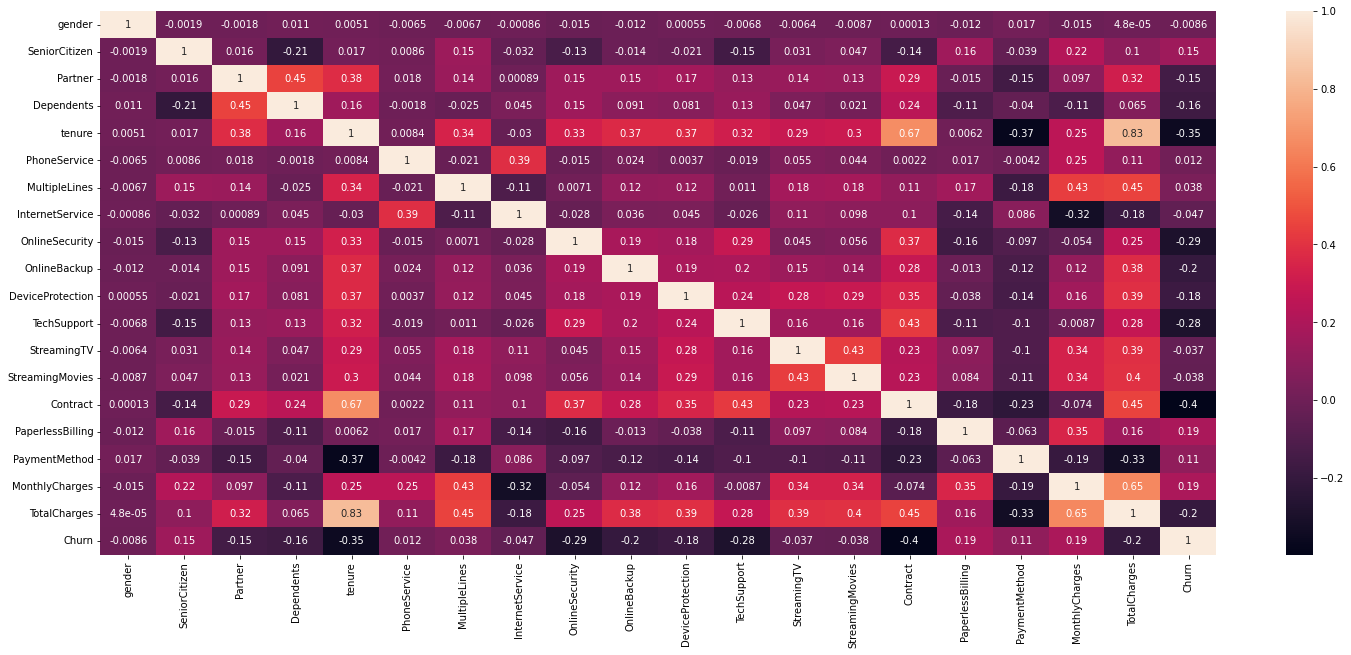

In [79]:
plt.figure(figsize=(25, 10))
sns.heatmap(labeling.corr(), annot=True)
plt.show()

We can see that there some of the feature that only have an impact or linked with *Target Column*, and all of them are trade off it means more less value of it's feature more chance to had a `Churn`

# Preprocessing

Before we start to train our data, we need to set *Fixed* data first

In [80]:
df.drop(columns='customerID', inplace=True)

## Spit Data

In [81]:
train, test = train_test_split(df, test_size=0.2, stratify= df['Churn'])
train, val = train_test_split(train, test_size = 0.15, stratify= train['Churn'])

In [82]:
print("Train data shape:", train.shape)
print("Test data shape:", test.shape)
print("Validation data shape:", val.shape)

Train data shape: (4788, 20)
Test data shape: (1409, 20)
Validation data shape: (846, 20)


#Label Encoding

In [83]:
label = LabelEncoder()
labeling = df.copy()
labeling['TotalCharges'] = pd.to_numeric(labeling['TotalCharges'], errors='coerce')
for i in labeling.select_dtypes('object'):
  labeling[i] = label.fit_transform(labeling[i])
labeling.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


In [84]:
labeling.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [85]:
labeling.dropna(inplace=True)

In [86]:
y_label = labeling['Churn']
X_label = labeling.iloc[:, :-1]
y_label.head()

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int64

#One Hot Encoding

There is a problem, for `TotalCharges` it's a categorical data and if we do `one hot encoder` without change the type of it's data type the column will so huge

In [87]:
encoder = df.copy()
encoder['TotalCharges'] = pd.to_numeric(encoder['TotalCharges'], errors='coerce')
encoder.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [88]:
encoder.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Because after we set to float we spot missing value on that, so we need to clean it first

In [89]:
encoder.dropna(inplace= True)

In [90]:
target = encoder['Churn'].map({'Yes': 1, 'No': 0})
encoder.drop(columns='Churn', inplace=True)

In [91]:
encoder = pd.get_dummies(encoder)
encoder.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0


In [92]:
X_ohe = encoder.copy()
y_ohe = target

# Model Definition

Label Encoding

In [93]:
data_train_label = tf.data.Dataset.from_tensor_slices((X_label, y_label))
data_train_label

<TensorSliceDataset shapes: ((19,), ()), types: (tf.float64, tf.int64)>

In [94]:
train_size = int(len(X_label)*0.9)
feature_shuffle = data_train_label.shuffle(1000)
train_data_label = feature_shuffle.take(train_size).batch(64)
train_data_label

<BatchDataset shapes: ((None, 19), (None,)), types: (tf.float64, tf.int64)>

In [95]:
val_size = int(train_size*0.8)
train_label = feature_shuffle.take(val_size).batch(64)
val_label = feature_shuffle.skip(val_size).take(val_size).batch(64)
test_label = feature_shuffle.skip(train_size).skip(val_size).batch(64)

One Hot Encoding

In [96]:
data_train_ohe = tf.data.Dataset.from_tensor_slices((X_ohe, y_ohe))
data_train_ohe

<TensorSliceDataset shapes: ((45,), ()), types: (tf.float64, tf.int64)>

In [97]:
train_size = int(len(X_ohe)*0.9)
feature_shuffle = data_train_ohe.shuffle(1000)
train_data_ohe = feature_shuffle.take(train_size).batch(64)
train_data_ohe

<BatchDataset shapes: ((None, 45), (None,)), types: (tf.float64, tf.int64)>

In [98]:
val_size = int(train_size*0.8)
train_ohe = feature_shuffle.take(val_size).batch(64)
val_ohe =feature_shuffle.skip(val_size).take(val_size).batch(64)
test_ohe = feature_shuffle.skip(train_size).skip(val_size).batch(64)

# Model Training

## Sequential API Label Encoder

In [99]:
normalizer_label = tf.keras.layers.Normalization(axis= -1)
normalizer_label.adapt(X_label)

In [100]:
model_label = tf.keras.Sequential([
                                   normalizer_label,
                                   Dense(16, activation='relu'),
                                   Dense(8, activation='relu'),
                                   Dense(4, activation='relu'),
                                   Dense(2, activation='relu'),
                                   Dense(1, activation='sigmoid'),
])

In [101]:
model_label.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics= ['accuracy'])

In [102]:
#Label Encoder
history_label = model_label.fit(train_data_label, epochs=100, validation_data= val_label, verbose=0)


## Sequential API One Hot Encoder

In [103]:
normalizer_ohe = tf.keras.layers.Normalization(axis= -1)
normalizer_ohe.adapt(X_ohe)

In [104]:
model_ohe = tf.keras.Sequential([
                                   normalizer_ohe,
                                   Dense(32, activation='relu'),
                                   Dense(16, activation='relu'),
                                   Dense(8, activation='relu'),
                                   Dense(4, activation='relu'),
                                   Dense(1, activation='sigmoid'),
])

In [105]:
model_ohe.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics= ['accuracy'])

In [106]:
#Ohe Encoder
history_ohe = model_ohe.fit(train_data_ohe, epochs=100, validation_data= val_ohe, verbose=0)

# Model Imrpovement

For Improvement, we gonna tune some of parameter model to see is there any chance that this model can be improve

In [107]:
input_ = tf.keras.layers.Input(shape= X_ohe.shape[1:])
normalizer_ = normalizer_ohe(input_)
hidden_ex = Dense(40, activation='relu')(normalizer_)
hidden_1 = Dense(32, activation='relu')(hidden_ex)
hidden_2 = Dense(16, activation='relu')(hidden_1)
hidden_3 = Dense(8, activation='relu')(hidden_2)
hidden_4 = Dense(4, activation='relu')(hidden_3)
# concat = tf.keras.layers.concatenate([hidden_3, hidden_4])
dropout_ = Dropout(rate=0.15)(hidden_4)
output = Dense(1, activation = 'sigmoid', kernel_initializer= 'he_normal')(dropout_)
model_functional = tf.keras.models.Model(inputs= input_, outputs=output)

In [108]:
model_functional.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics= ['accuracy'])

And here's the architecture of `Functional API`

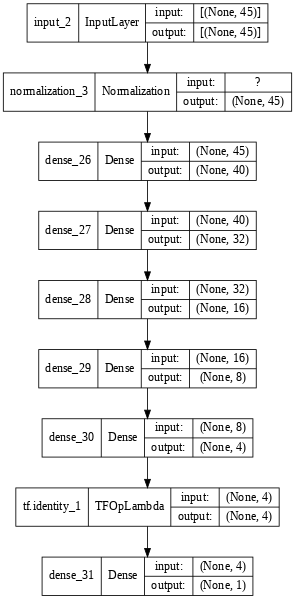

In [109]:
tf.keras.utils.plot_model(model_functional, show_shapes=True, dpi=60)

In [110]:
#Functional API
history_funct = model_functional.fit(train_data_ohe, epochs=100, validation_data= val_ohe, verbose=0)

### Model Saving

In [111]:
model_functional.save('model_improvement.h5')

# Model Evaluation

### Label Encoding Model

In [112]:
print('Training Loss:', np.mean(history_label.history['loss']))
print('Training Accuracy:', np.mean(history_label.history['accuracy']))
print("Validation's Loss:", np.mean(history_label.history['val_loss']))
print("Validation's Accuracy:", np.mean(history_label.history['val_accuracy']))

Training Loss: 0.3963275596499443
Training Accuracy: 0.8124241483211517
Validation's Loss: 0.41090467780828477
Validation's Accuracy: 0.8082791882753372


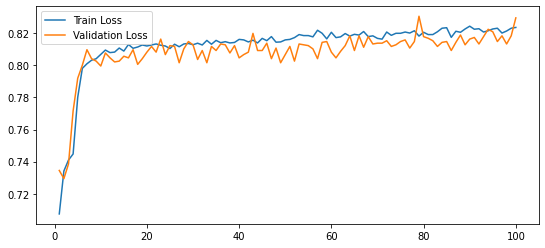

In [113]:
x_axis = np.arange(1,101)
plt.figure(figsize=(9, 4))

plt.plot(x_axis, history_label.history['accuracy'], label='Train Loss')
plt.plot(x_axis, history_label.history['val_accuracy'], label='Validation Loss')
plt.legend()
plt.show()

### One Hot Encoding Model

In [114]:
print('Training Loss:', np.mean(history_ohe.history['loss']))
print('Training Accuracy:', np.mean(history_ohe.history['accuracy']))
print("Validation's Loss:", np.mean(history_ohe.history['val_loss']))
print("Validation's Accuracy:", np.mean(history_ohe.history['val_accuracy']))

Training Loss: 0.35139305263757703
Training Accuracy: 0.8418489223718644
Validation's Loss: 0.3641344675421715
Validation's Accuracy: 0.8374923872947693


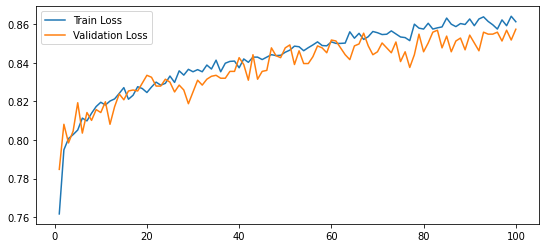

In [115]:
x_axis = np.arange(1,101)
plt.figure(figsize=(9, 4))

plt.plot(x_axis, history_ohe.history['accuracy'], label='Train Loss')
plt.plot(x_axis, history_ohe.history['val_accuracy'], label='Validation Loss')
plt.legend()
plt.show()

### Model Improvement 

In [116]:
print('Training Loss:', np.mean(history_funct.history['loss']))
print('Training Accuracy:', np.mean(history_funct.history['accuracy']))
print("Validation's Loss:", np.mean(history_funct.history['val_loss']))
print("Validation's Accuracy:", np.mean(history_funct.history['val_accuracy']))

Training Loss: 0.3182322382926941
Training Accuracy: 0.8526596057415009
Validation's Loss: 0.32534262999892233
Validation's Accuracy: 0.8538984775543212


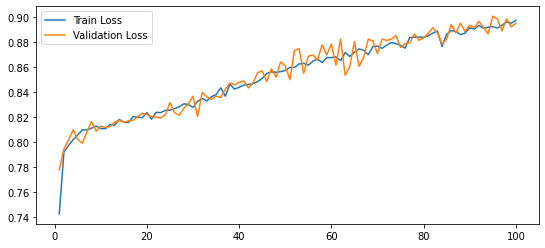

In [117]:
x_axis = np.arange(1,101)
plt.figure(figsize=(9, 4))

plt.plot(x_axis, history_funct.history['accuracy'], label='Train Loss')
plt.plot(x_axis, history_funct.history['val_accuracy'], label='Validation Loss')
plt.legend()
plt.show()

And here's the comparison between `Label Encoding`, `One Hot Encoding` and `Model Improvement`

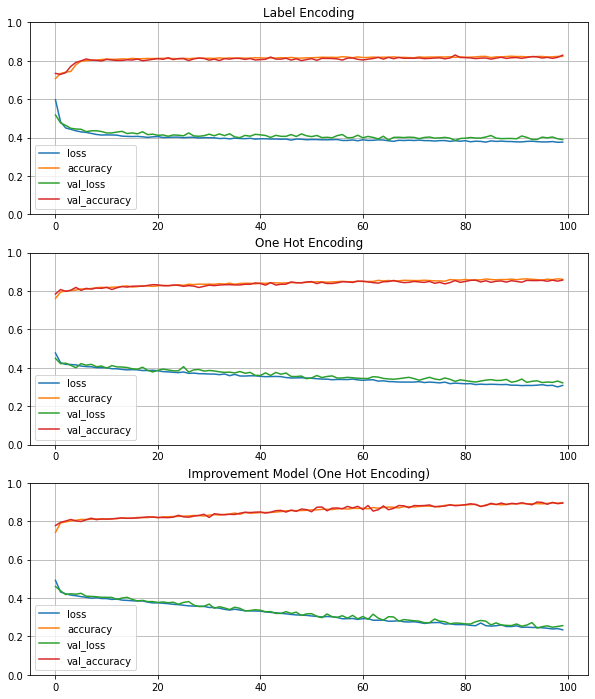

In [118]:
fig, ax = plt.subplots(nrows=3, figsize=(10, 12))
pd.DataFrame(history_label.history).plot(ax=ax[0])
pd.DataFrame(history_ohe.history).plot(ax=ax[1])
pd.DataFrame(history_funct.history).plot(ax=ax[2])
ax[0].grid(True)
ax[0].set_ylim(0, 1)
ax[0].set_title("Label Encoding")
ax[1].grid(True)
ax[1].set_ylim(0, 1)
ax[1].set_title("One Hot Encoding")
ax[2].grid(True)
ax[2].set_ylim(0, 1)
ax[2].set_title("Improvement Model (One Hot Encoding)")
plt.show()

We can tell that `One Hot Encoder` is a right choice to *encode* the categorical data, because it more accurate to tell dependent features value rather than `Label Encoder`. 

We get slightly better result after tune our parameter model with adding `Dropout with 1.5 rate`, `Additional hidden layer`, `Kernel Initializer` 
and get:


In [119]:
train_loss = round(np.min(history_ohe.history['loss']), 3) - round(np.min(history_funct.history['loss']), 3)
val_loss = round(np.min(history_ohe.history['val_loss']), 3) - round(np.min(history_funct.history['val_loss']), 3)
train_acc = round(np.max(history_funct.history['accuracy']), 3) - round(np.max(history_ohe.history['accuracy']), 3)
val_acc = round(np.max(history_funct.history['val_accuracy']), 3) - round(np.max(history_ohe.history['val_accuracy']), 3)
print('Reduction Training Loss from {} to {} ({})'.format(round(np.min(history_ohe.history['loss']), 3),
                                           round(np.min(history_funct.history['loss']), 3), round(train_loss, 3)))
print('Reduction Validation Loss from {} to {} ({})'.format(round(np.min(history_ohe.history['val_loss']), 3),
                                           round(np.min(history_funct.history['val_loss']), 3), round(val_loss, 3)))
print('Increament Training Accuracy from {} to {} ({})'.format(round(np.max(history_ohe.history['accuracy']), 3),
                                           round(np.max(history_funct.history['accuracy']), 3), round(train_acc, 3)))
print('Increament Validation Accuracy from {} to {} ({})'.format(round(np.max(history_ohe.history['val_accuracy']), 3),
                                           round(np.max(history_funct.history['val_accuracy']), 3), round(val_acc, 3)))

Reduction Training Loss from 0.3 to 0.234 (0.066)
Reduction Validation Loss from 0.322 to 0.243 (0.079)
Increament Training Accuracy from 0.864 to 0.897 (0.033)
Increament Validation Accuracy from 0.857 to 0.901 (0.044)


# Model Inference

Before we predict data test, that we prepare we need to load our model that we've save

In [120]:
load_model = keras.models.load_model('model_improvement.h5')
load_model

In [121]:
X_test = X_ohe.sample(10, random_state=11)
y_test = y_ohe.sample(10, random_state=11)

In [122]:
new_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
new_data

<TensorSliceDataset shapes: ((45,), ()), types: (tf.float64, tf.int64)>

In [123]:
predict = np.argmax(load_model.predict(X_test), axis=-1)
rename = np.array(['No','Yes'])[predict]
X_test['Prediction'] = predict
X_test.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Prediction
6466,0,18,74.15,1387.0,0,1,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
5615,0,1,20.20,20.2,0,1,1,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,1,0,0,0,0
5344,0,71,76.90,5522.7,0,1,1,0,0,1,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,1,0,1,0,0,0
5564,0,35,55.25,1924.1,0,1,1,0,1,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0
588,0,72,99.15,7422.1,0,1,0,1,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0


# Summary

## EDA Analysis


- This dataset is about `Telco Customer` who have `Churn` and who doesn't
- There is no duplicated data, but `CustomerID` was useless feature for this case which will be used for `predicting customer churn`
- At first there is no missing value, but when you change data type of `Total Charges`, missing value will show but it's only 11 so I remove it
- `Customer Churn` which is target column turns out it is `Imbalance Data`, with percentage of customer who have `churn only 26%` and rest of it doesn't Churn 
- Service of the product are `Streaming TV` include `Streaming Movie`
- Most of customer are young pepople, but the ratio of customer who have tendency to `Churn` more are `Senior Citizen`
- Customer who `doesn't have partner` (and of course `dependents`) have more chance to `Churn`
- Most of customer likely to `Churn` when it's *Monthly*, because it's cheaper and more flexible
- And lastly, there is no outlier on this dataset

## Model Analysis

- In this case I'll try to devide two type of treatment for categorical data: `Label Encoder` & `One Hot Encoder`
- Label Encoder gives `19 Feature` & One Hot Encoder gives `45 Feature`
` Both of them have same parameters, but as I predicted the result shows differently
- `One Hot Encoder` performs better, the reason was because the categorical features on this data are dependent type it means there is no order for a column so it means it is better to check every combinations of categorical 1 by 1
- type of categorical like this called `Nominal categorical` and it performs better with `One Hot Encoder`
- We can see from **Evaluation** step, `OHE` has tendency to increase while epoch (iterarations) increased compare to `Label` which is stagnant
- `OHE` on the epoch 100 has `0.05` Training Loss and `0.02` Training Accuracy better than `Label`
- For improvement model, of course I use `OHE` model with little changes on parameters
- I add `1 Hidden Layer`, `1 Dropout layer` (rate=0.15), and define `kernel initializer` on the output layer
- And the result so much better, I can say that because the improvement get better and the imrpovement can get more if added more epoch (iterations)
- I can't make sure how big the difference of the result, the reason was because everytime this data run, it always perform better and better again
- For now the result was:

> - Reduction Training Loss from 0.301 to 0.214 (0.087) ------------> min
> - Reduction Validation Loss from 0.329 to 0.226 (0.103) ---------> min
> - Increament Training Accuracy from 0.858 to 0.902 (0.044) ---> max
> - Increament Validation Accuracy from 0.848 to 0.897 (0.049) > max